# Prediction Modeling
- 데이터 분석 결과를 기반으로 예측 모델링 실시
- 다중 분류(Multi-class classification) 문제

## 배경

- 코로나 바이러스(Covid19)로 인해 수많은 입원환자가 발생하여 여러 병원들의 병상 부족 문제 발생

## 목적

- 환자의 여러가지 특성 데이터를 기반으로 입원 환자 개개인의 예상 재원일수를 예측하여 해당 환자에게 최적화된 치료법을 수행하고 의료진과 병원 방문객들의 집단 감염을 막기 위함

## 가설

- 환자기 입원한 병원의 유형, 입원 환자의 질환 종류, 병실 유형, 병실 시설 유형, 환자동반 방문객 수, 총 5개의 변수가 재원일수에 영향을 미칠 것으로 판단
    * 특히 ``환자 동반 방문객 수는 재원일수와 0.5 라는 양의 상관계수``를 보임

## 데이터 로드

In [52]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare')
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (318438, 18)
Test shape:  (137057, 17)


In [53]:
# 중복 데이터 존재 여부 확인 -> 중복 데이터는 없음
train.duplicated().sum()

0

## 종속변수에 대한 이해

- 종속변수 : Stay(재원일수)
    * 범주형 변수(범위화 되어 있음)
    * 클래스 개수 : 11개
    * 종속변수 분포 : 클래스 불균형 존재

In [54]:
# 종속변수에 대한 간단한 탐색
print("# 종속변수 Level 개수: ", train['Stay'].nunique(),'\n')
print("# 종속변수 Level 종류: ", train['Stay'].unique(),'\n')
print("# 종속변수 Level 개수 분포\n", train['Stay'].value_counts())

# 종속변수 Level 개수:  11 

# 종속변수 Level 종류:  ['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100'] 

# 종속변수 Level 개수 분포
 21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64


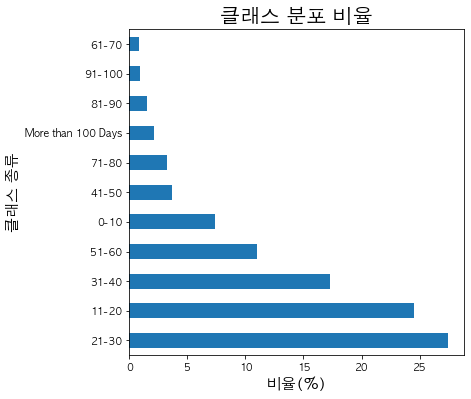

In [55]:
# 클래스 분포 비율로 나타낸 후 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(6,6))

class_ratio = np.round((train['Stay'].value_counts() / train['Stay'].value_counts().values.sum()) * 100, 2)
class_ratio.plot.barh()
plt.title("클래스 분포 비율", fontsize=20)
plt.xlabel("비율(%)", fontsize=15)
plt.ylabel("클래스 종류", fontsize=15)
plt.show()

**클래스 불균형 해결 방법**

- ``언더샘플링``
    - 언더 샘플링으로 데이터 개수를 줄이기에는 원본 데이터가 많은 편이 아니기 떄문에 부적절로 판단<br><br>

- ``오버샘플링``
    - 클래스 불균형이 심한 상태로 오버 샘플링을 해주어야 한다.(단 Train데이터에서만)
    - 그리고 오버 샘플링을 수행한 후 교차검증을 수행해주어야 한다.
        * 왜냐하면 클래스 불균형 상태에서 모델이 학습한 후 도출되는 높은 성능은 어떤 데이터가 들어올지 모르는 테스트 데이터에서 **과대적합 문제**가 발생할 수 있기 때문이다. 따라서 최대한 ``어떤 데이터가 들어왔을 때도 잘 예측할 수 있도록 학습하기 위해 클래스 불균형을 해소한 후 교차검증을 적용``시켜야 한다.
<br><br>   
- ``Cost-sensitive Learning``
    - 학습 시 ``클래스 개수가 적은 데이터쪽으로 편향되어 학습``하도록 하는 방법
    - 클래스 개수에 따라 자동으로 balanced인자 넣어주어서 가중치 부여
    - 클래스 개수에 따른 weight를 직접 커스터마이징해서 부여

## 독립변수에 대한 이해

- 수치형 변수, 범주형 변수 구분
- 독립변수로부터 파생변수 생성

In [56]:
# 수치형 변수, 범주형 변수 구분
num_cols = ['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit']
num_df = train[num_cols]
cate_df = train.drop(num_cols, axis=1)
category_cols = cate_df.columns.tolist()
category_cols.remove('Stay')

print("# 수치형 변수 :", num_df.columns.tolist(),'\n')
print("# 범주형 변수 :\n", category_cols)

# 수치형 변수 : ['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit'] 

# 범주형 변수 :
 ['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Age']


### 수치형 변수

- 데이터 분석 결과를 기반으로 하여<br><br>
    * Available Extra Rooms in Hospital(여분 병실수)
        - 해당 변수는 종속변수와 관계가 없는 것으로 도출
        - 따라서 **변수 삭제 또는 파생변수 생성**에 이용<br><br>
    * Visitors with Patient(환자 동반 방문객 수)
        - 해당 변수는 종속변수와 양의 상관관계를 보이며 깊은 관계가 있는 것으로 도출
        - 따라서 **이상치 관찰 후 스케일링 적용 여부 판단 후 변수 그대로 사용**<br><br>
    * Admission_Deposit(입원 보증금)
        - 해당 변수는 종속변수와 관계가 없는 것으로 도출
        - 따라서 **변수 삭제 또는 파생변수 생성**에 이용

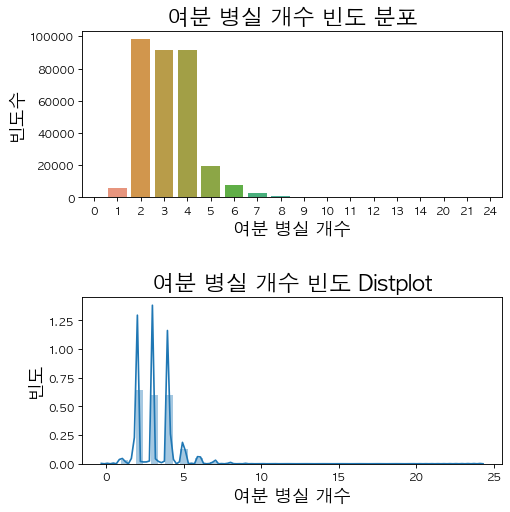

In [91]:
# 여분 병실수 변수 분포(countplot & distplot)
fig, axes = plt.subplots(figsize=(6,6), ncols=1, nrows=2, dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
sns.countplot(x=num_df['Available Extra Rooms in Hospital'], ax=axes[0])
sns.distplot(num_df['Available Extra Rooms in Hospital'], ax=axes[1])

axes[0].set_title("여분 병실 개수 빈도 분포", fontsize=20)
axes[0].set_xlabel("여분 병실 개수", fontsize=16)
axes[0].set_ylabel("빈도수", fontsize=16)
axes[1].set_title("여분 병실 개수 빈도 Distplot", fontsize=20)
axes[1].set_xlabel("여분 병실 개수", fontsize=16)
axes[1].set_ylabel("빈도", fontsize=16)
plt.show()

- 정규분포 형태를 띄진 않음
- 종속변수와 관계가 없는 변수이기 떄문에 정규분포화 시켜줄 필요까진 없음

In [ ]:
# 환자 동반 방문객 수(countplot, distplot)
num_df['Available Extra Rooms in Hospital'].plot.bar()